# Classification on MNIST Dataset using `mfnet`

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets
from torchvision.transforms import ToTensor

from mfnet.dataloader import BatchIterator
from mfnet.layer import Linear, ReLU
from mfnet.nn import NeuralNetwork
from mfnet.tensor import Tensor, tensor
from mfnet.train import train_test_classification
from mfnet.trainutils import one_hot_decode, one_hot_encode


In [2]:
plt.style.use(
    [
        f"../mplstyles/{style}.mplstyle"
        for style in ["grid", "science", "notebook", "mylegend"]
    ],
)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## Load Data

In [3]:
training_data = datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor(),
)

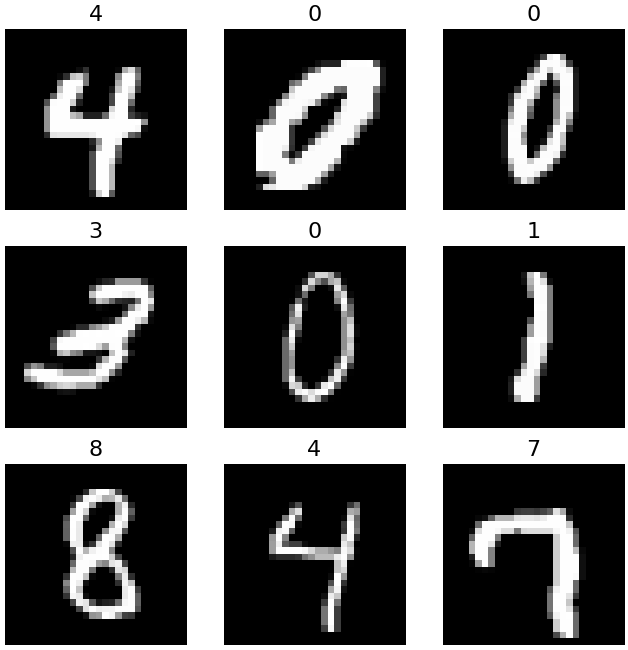

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
rng = np.random.default_rng()
for i in range(1, cols * rows + 1):
    sample_idx = rng.integers(len(training_data))
    img, label = training_data[sample_idx]
    img = img.numpy().squeeze()
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

### Data preprocessing

`training_data.data` contains the image data, with shape `(num_samples, W, H)` (W = H = 28 for MNIST), and `training_data.targets` contains the labels, with shape `num_samples`.

To make the data compatible with the library, we need the input tensor to have shape `(num_samples, num_features)`, where `num_features = W * H`, and the target tensor to have shape `(num_samples, num_classes)`, where `num_classes` is the number of classes (10 for MNIST).

The input is then normalized to the range [0, 1] by dividing by 255.

In [5]:
def preprocess_data(raw_data: datasets.mnist.MNIST) -> tuple[Tensor, Tensor]:
    img_size = np.array([28, 28])
    _features = tensor(raw_data.data).reshape(-1, img_size.prod())
    _labels = tensor(raw_data.targets).reshape(-1, 1)
    features = _features / 255.0
    labels = one_hot_encode(_labels + 1, num_classes=10)
    return features, labels

In [6]:
x_train, y_train = preprocess_data(training_data)
x_test, y_test = preprocess_data(test_data)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


## Training

In [14]:
NUM_EPOCHS = 100
TEST_INTERVAL = 1
LEARNING_RATE = 1e-3
BATCH_SIZE = 1024
INPUT_SIZE = 28 * 28
NUM_CLASSES = 10
SAVEFIG = True

train_dataloader = BatchIterator(batch_size=BATCH_SIZE, shuffle=True)
train = partial(
    train_test_classification,
    train_inputs=x_train,
    train_targets=y_train,
    test_inputs=x_test,
    test_targets=y_test,
    num_epochs=NUM_EPOCHS,
    test_interval=TEST_INTERVAL,
    lr=LEARNING_RATE,
    dataloader=train_dataloader,
)

### Linear model benchmark

In [15]:
lin_model = NeuralNetwork([Linear(INPUT_SIZE, NUM_CLASSES)])

lin_train_losses, _, lin_test_losses, lin_test_accuracies = train(lin_model)

### Neural Network

In [16]:
nn_model = NeuralNetwork(
    [
        Linear(INPUT_SIZE, 512),
        ReLU(),
        Linear(512, 512),
        ReLU(),
        Linear(512, NUM_CLASSES),
    ],
)

nn_train_losses, _, nn_test_losses, nn_test_accuracies = train(nn_model)

## Plotting

### Learning Curves

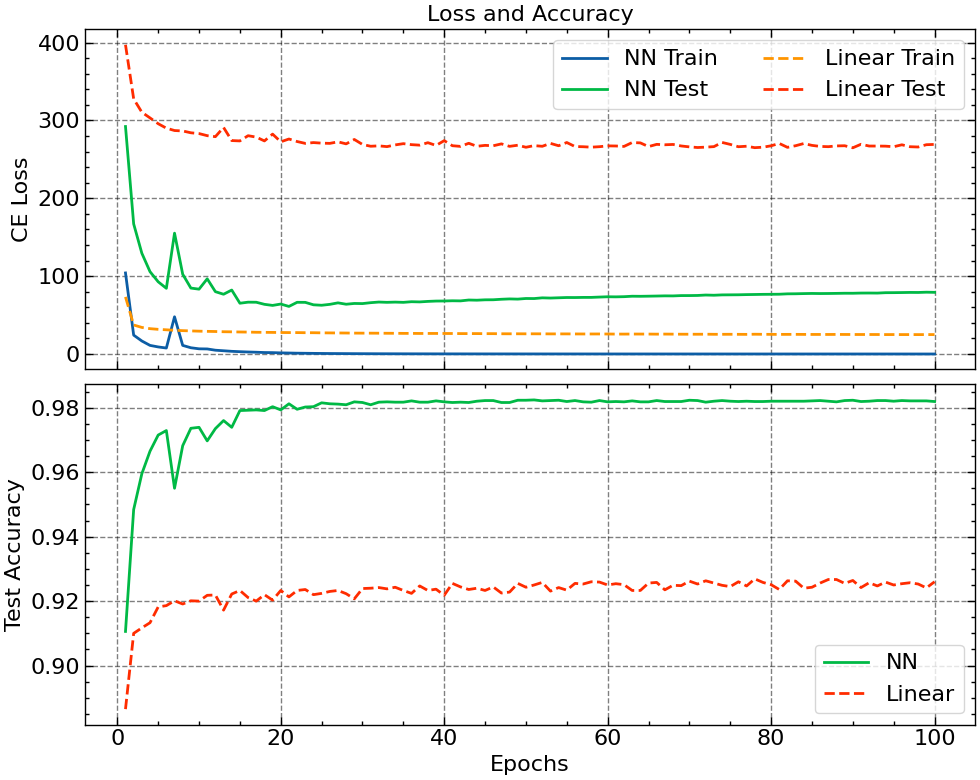

In [17]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
if TEST_INTERVAL == 1:
    test_epochs = list(range(1, NUM_EPOCHS + 1, TEST_INTERVAL))
else:
    test_epochs = [*list(range(1, NUM_EPOCHS + 1, TEST_INTERVAL)), NUM_EPOCHS]

ax = axes[0]
ax.plot(range(1, NUM_EPOCHS + 1), nn_train_losses, label="NN Train")
ax.plot(test_epochs, nn_test_losses, label="NN Test")
ax.plot(
    range(1, NUM_EPOCHS + 1),
    lin_train_losses,
    label="Linear Train",
    linestyle="--",
)
ax.plot(test_epochs, lin_test_losses, label="Linear Test", linestyle="--")

ax.set_ylabel("CE Loss")
ax.set_title("Loss and Accuracy")

ax.legend(ncols=2)

ax = axes[1]
ax.plot(test_epochs, nn_test_accuracies, label="NN", color=colors[1])
ax.plot(
    test_epochs,
    lin_test_accuracies,
    label="Linear",
    linestyle="--",
    color=colors[3],
)

ax.set_xlabel("Epochs")
ax.set_ylabel("Test Accuracy")

ax.legend()

fig.tight_layout()
plt.show()

if SAVEFIG:
    fig.savefig(
        f"./images/mfnet_class_loss_acc_{NUM_EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}.png",
        dpi=200,
    )

In [18]:
def confusion_matrix(
    model: NeuralNetwork,
) -> np.ndarray[tuple[int, int], np.dtype[np.int64]]:
    test_dataloader = BatchIterator(batch_size=-1, shuffle=False)
    num_classes = NUM_CLASSES
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
    for batch in test_dataloader(x_test, y_test):
        images, labels = batch.inputs, batch.targets
        labels = one_hot_decode(labels[1:].T) - 1
        preds = np.argmax(model.forward(images), axis=0) - 1
        for t, p in zip(labels, preds, strict=True):
            conf_matrix[t, p] += 1
    return conf_matrix

In [19]:
lin_conf_matrix = confusion_matrix(lin_model)
nn_conf_matrix = confusion_matrix(nn_model)

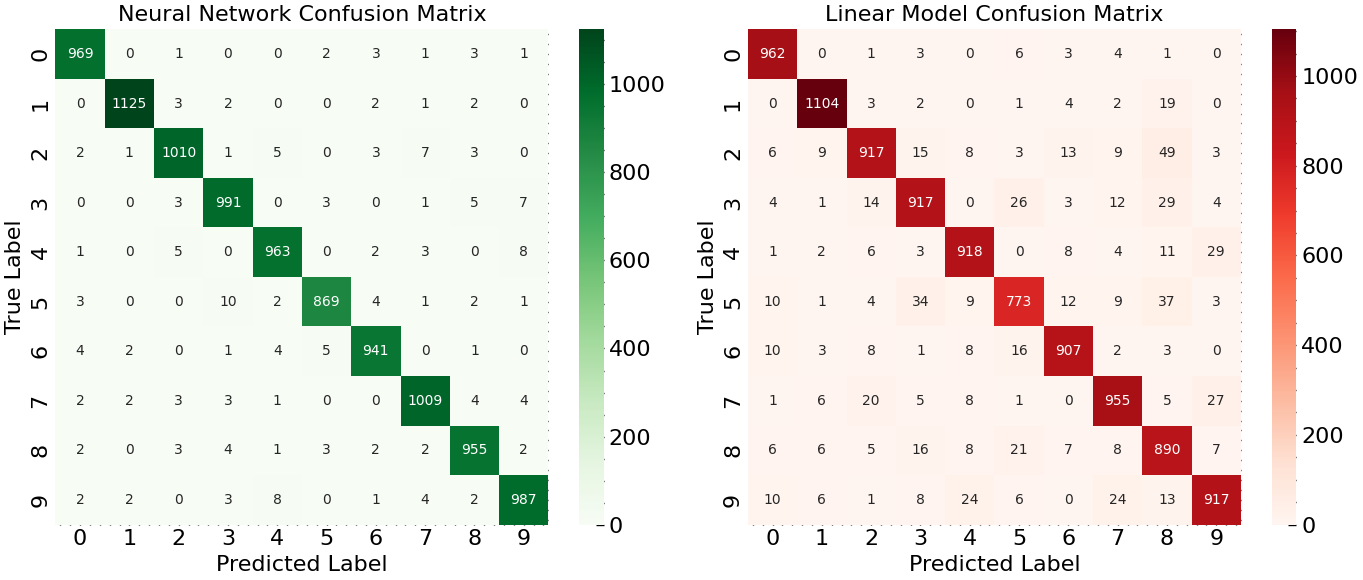

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
sns.heatmap(nn_conf_matrix, annot=True, fmt="d", ax=ax, cmap="Greens")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Neural Network Confusion Matrix")

ax = axes[1]
sns.heatmap(lin_conf_matrix, annot=True, fmt="d", ax=ax, cmap="Reds")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Linear Model Confusion Matrix")

fig.tight_layout()
plt.show()

if SAVEFIG:
    fig.savefig(
        f"./images/mfnet_class_conf_matrix_{NUM_EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}.png",
        dpi=200,
    )